# WMT of $\frac{d}{dt}M_\Omega(\theta)$
> where $\Omega$ is the surface boundary of the WWM of the MHW event in $\theta$ space

> `dMdt` term comes from GLORYS

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import dask
import dask.array as dsa
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
#import regionate as reg

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gopaf_pottemp = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOPAF/datasets/3D-pottemp.zarr'))

In [3]:
gopaf_pottemp

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 109, longitude: 337, time: 304)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00
Data variables:
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 109, 337), meta=np.ndarray>
Attributes: (12/13)
    Conventions:       CF-1.8
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    area:              Global
    comment:           
    contact:           https://marine.copernicus.eu/contact
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    ...                ...
    institution:       Mercator Ocean International
    licence:           http://marine.copernicus.eu/services-portfolio/service...
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    references:        http://marine.copernicus.eu
    source:            MOI GLO12
    title:             daily mean fields from Global Ocean Physics Analysis a...

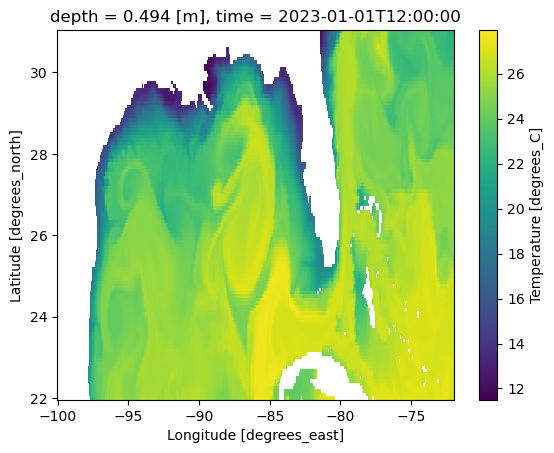

In [4]:
gopaf_pottemp.thetao[0,0].plot()

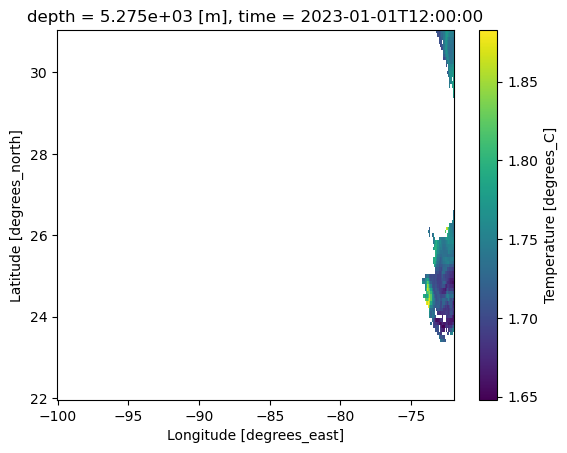

In [36]:
gopaf_pottemp.thetao[0,-2].plot()

## Create grid and area objects

In [8]:
ds_pt_full = generate_grid_ds(gopaf_pottemp, {'X':'longitude', 'Y':'latitude'})
grid_pt_full = xgcm.Grid(ds_pt_full, periodic=['X', 'Y'])#, boundary="fill", fill_value=0.)

In [9]:
grid_pt_full

<xgcm.Grid>
Y Axis (periodic, boundary=None):
  * center   latitude --> left
  * left     latitude_left --> center
X Axis (periodic, boundary=None):
  * center   longitude --> left
  * left     longitude_left --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   depth

In [10]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
   
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}'].astype('f4')))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left'].astype('f4')))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [11]:
cell_elements_glorys = deg_2_m(grid_pt_full, ds_pt_full, 'latitude', 'longitude')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


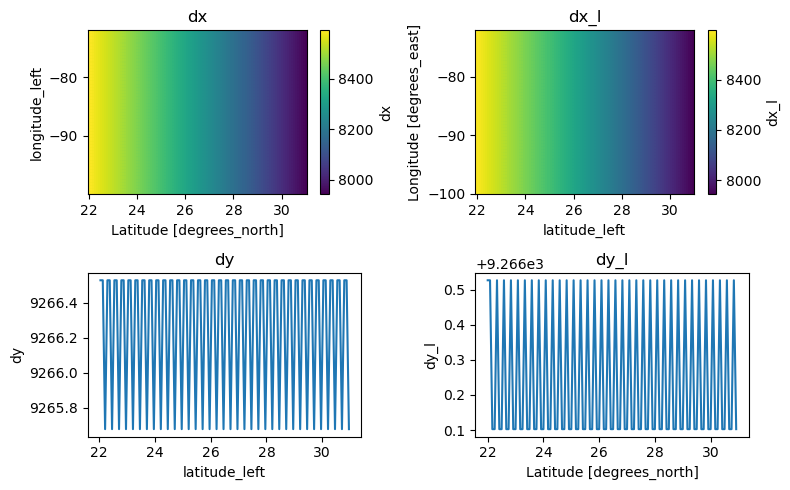

In [12]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_glorys.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_glorys.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_glorys.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_glorys.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

In [13]:
mask_pt = gopaf_pottemp.thetao.isel(time=0, depth=0).isnull()

/tmp/ipykernel_555/3224994717.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


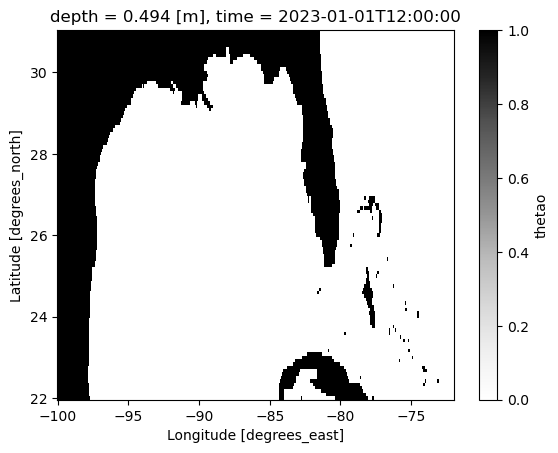

In [14]:
cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_pt.plot(cmap=cmap)

In [15]:
gopaf_pottemp.thetao[180]

<xarray.DataArray 'thetao' (depth: 50, latitude: 109, longitude: 337)>
dask.array<getitem, shape=(50, 109, 337), dtype=float32, chunksize=(50, 109, 337), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
    time       datetime64[ns] 2023-06-30T12:00:00
Attributes:
    _ChunkSizes:    [1, 6, 256, 540]
    cell_methods:   area: mean
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    unit_long:      Degrees Celsius
    units:          degrees_C

/tmp/ipykernel_555/854029517.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


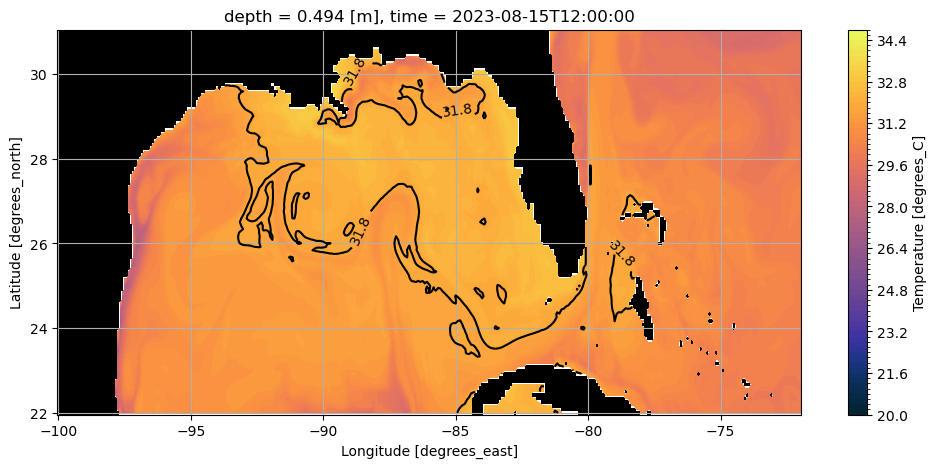

In [16]:
plt.figure(figsize=(12,5))

cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_pt.plot(cmap=cmap, add_colorbar=False)

gopaf_pottemp.thetao[226,0].plot.contourf(levels=np.arange(20, 35, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = gopaf_pottemp.thetao[226,0].plot.contour(levels=[31.8], colors='k')
plt.clabel(c)
plt.grid();

### Calculate surface area of 31.8˚C contour

In [17]:
sst_2023_gopaf = gopaf_pottemp.thetao.isel(depth=0).sel(time=slice('2023-01-01', '2023-09-28'))
sst_2023_gopaf

<xarray.DataArray 'thetao' (time: 271, latitude: 109, longitude: 337)>
dask.array<getitem, shape=(271, 109, 337), dtype=float32, chunksize=(1, 109, 337), chunktype=numpy.ndarray>
Coordinates:
    depth      float32 0.494
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-09-28T12:00:00
Attributes:
    _ChunkSizes:    [1, 6, 256, 540]
    cell_methods:   area: mean
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    unit_long:      Degrees Celsius
    units:          degrees_C

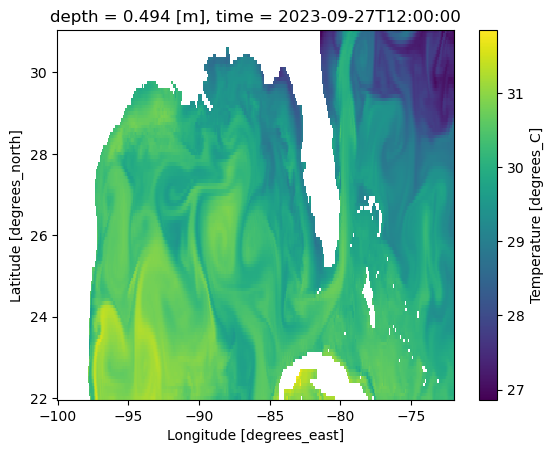

In [18]:
sst_2023_gopaf.sel(time='2023-09-27').plot()

In [19]:
wwm = sst_2023_gopaf.where(sst_2023_gopaf>=31.8)

In [20]:
wwm

<xarray.DataArray 'thetao' (time: 271, latitude: 109, longitude: 337)>
dask.array<where, shape=(271, 109, 337), dtype=float32, chunksize=(1, 109, 337), chunktype=numpy.ndarray>
Coordinates:
    depth      float32 0.494
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-09-28T12:00:00
Attributes:
    _ChunkSizes:    [1, 6, 256, 540]
    cell_methods:   area: mean
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    unit_long:      Degrees Celsius
    units:          degrees_C

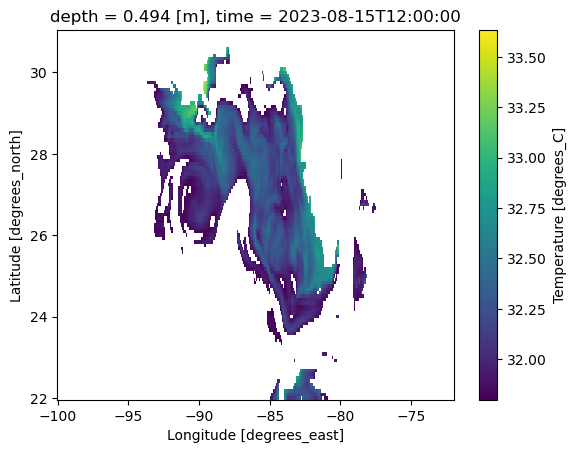

In [21]:
wwm.sel(time='2023-08-15').plot()

In [22]:
dx_interp = grid_pt_full.interp(cell_elements_glorys.dx_l, 'Y')

area = cell_elements_glorys.dy_l * dx_interp
wwm_area_weighted = wwm * area

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [23]:
wwm_area_weighted

<xarray.DataArray (time: 271, latitude: 109, longitude: 337)>
dask.array<mul, shape=(271, 109, 337), dtype=float32, chunksize=(1, 109, 337), chunktype=numpy.ndarray>
Coordinates:
    depth      float32 0.494
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-09-28T12:00:00

In [24]:
tot_area_2023 = wwm_area_weighted.sum(['latitude', 'longitude', 'time'])

In [25]:
tot_area_2023.compute()

<xarray.DataArray ()>
array(3.355318e+14, dtype=float32)
Coordinates:
    depth    float32 0.494

In [26]:
area.coords

Coordinates:
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0

In [27]:
wwm.sel(time='2023-08-15', method='nearest').coords

Coordinates:
    depth      float32 0.494
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
    time       datetime64[ns] 2023-08-15T12:00:00

In [28]:
max_vol_area = wwm.sel(time='2023-08-15', method='nearest') * area

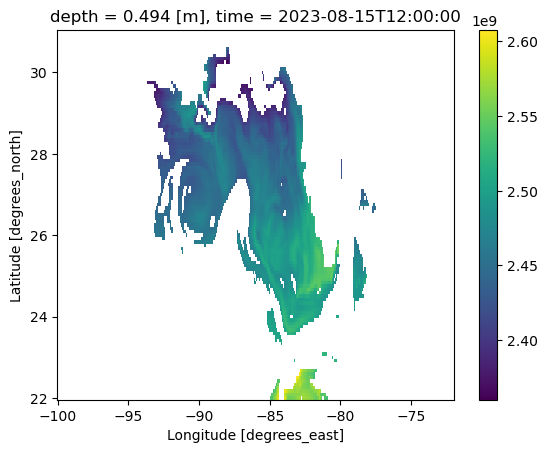

In [29]:
max_vol_area.plot()

In [30]:
max_vol_area.sum(['latitude', 'longitude']).values

array(1.5980365e+13, dtype=float32)

In [31]:
wwm_area_weighted.sum(['latitude', 'longitude']).argmax().values

array(225)

In [32]:
wwm_area_weighted[225].sum(['latitude', 'longitude']).values

array(1.6098694e+13, dtype=float32)

# `dVdt` using `.where(thetao>=31.8)`

In [69]:
dx_interp = grid_pt_full.interp(cell_elements_glorys.dx_l, 'Y')

dz = gopaf_pottemp.depth.diff(dim='depth', label='upper')
vol = cell_elements_glorys.dy_l * dx_interp[:-1,:] * dz
masked_vol = vol.where(gopaf_pottemp.thetao[:, 1:, :, :-1]>=31.8) #m^3
vol_tot = masked_vol.sum(['latitude', 'longitude', 'depth']) #m^3
M = vol_tot * 1034 #kg
V = M / 1034 #m^3

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [70]:
dx_interp.coords

Coordinates:
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0

In [71]:
gopaf_pottemp.thetao[:,1:,:,:].coords

Coordinates:
  * depth      (depth) float32 1.541 2.646 3.819 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00

In [72]:
V

<xarray.DataArray (time: 304)>
dask.array<truediv, shape=(304,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00

In [73]:
V.load()

<xarray.DataArray (time: 304)>
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
...
       4.04216742e+12, 3.58660388e+12, 3.26509370e+12, 2.37990602e+12,
       1.18685395e+12, 5.27484060e+11, 4.21409882e+11, 4.68438647e+11,
       4.15441519e+11, 4.55413334e+11, 5.70229457e+11, 7.00543009e+11,
       6.26641011e+11, 2.64732819e+11, 1.50436381e+11, 1.85961759e+11,
       1.20460616e+11, 4.85082778e+09, 1.75864371e+09, 8.79143296e+08,
       4.39551488e+08, 4.39551488e+08, 8.79143296e+08, 3.05011488e+08,
       5.75126208e+08, 5.56785344e+08, 3.24294989e+09, 1.85140797e+10,
       2.91097764e+10, 4.05178409e+10, 6.20992430e+10, 1.16794335e+11,
       1.42144930e+11, 1.58773543e+11, 1.15309003e+11, 9.41187891e+10,
       9.64800348e+10, 8.92238807e+10, 8.18579866e+10, 5.47006956e+10,
       1.01209764e+10, 1.50215501e+09, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00

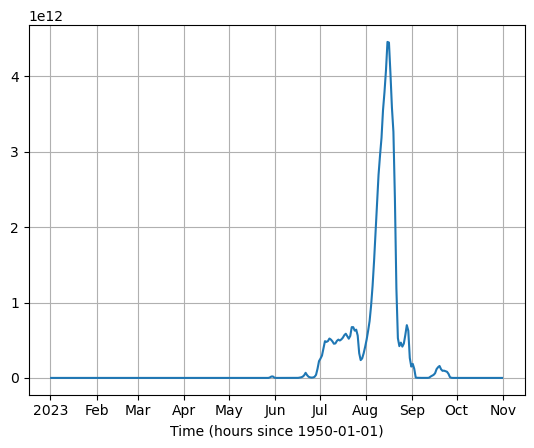

In [74]:
V.plot()
plt.grid()

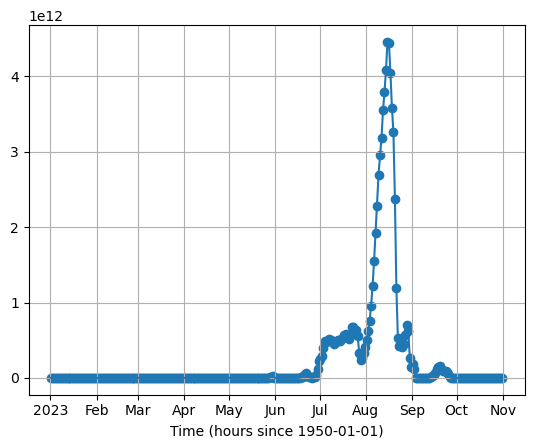

In [75]:
V.plot()
plt.scatter(V.time, V)
plt.grid()

In [76]:
dt_values = (np.diff(V.time)/1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], coords={'time':(['time'], V.time.values[1:])})

In [77]:
V.diff('time', label='upper').time

<xarray.DataArray 'time' (time: 303)>
array(['2023-01-02T12:00:00.000000000', '2023-01-03T12:00:00.000000000',
       '2023-01-04T12:00:00.000000000', ..., '2023-10-29T12:00:00.000000000',
       '2023-10-30T12:00:00.000000000', '2023-10-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-01-02T12:00:00 ... 2023-10-31T12:00:00
Attributes:
    _ChunkSizes:          1024
    _CoordinateAxisType:  Time
    axis:                 T
    long_name:            Time (hours since 1950-01-01)
    standard_name:        time
    valid_max:            640668.0
    valid_min:            639924.0

In [78]:
dt.time

<xarray.DataArray 'time' (time: 303)>
array(['2023-01-02T12:00:00.000000000', '2023-01-03T12:00:00.000000000',
       '2023-01-04T12:00:00.000000000', ..., '2023-10-29T12:00:00.000000000',
       '2023-10-30T12:00:00.000000000', '2023-10-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-01-02T12:00:00 ... 2023-10-31T12:00:00

In [79]:
dt[0:3].values

array([86400., 86400., 86400.], dtype=float32)

In [80]:
dVdt = V.diff('time', label='upper') / dt #m^3/s

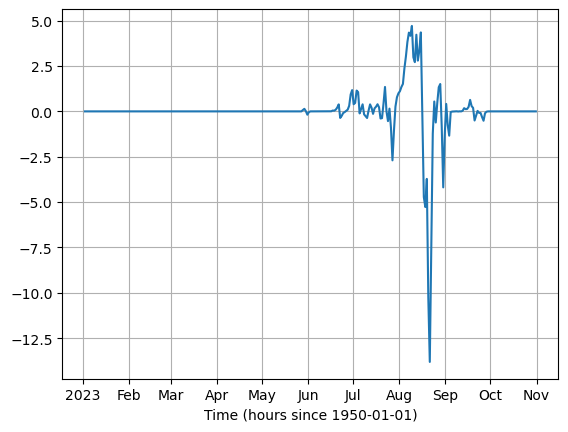

In [81]:
(dVdt/1e6).plot()
plt.grid()

# `dVdt` using `histogram(thetao, weights=vol)`

In [24]:
dx_interp = grid_pt_full.interp(cell_elements_glorys.dx_l, 'Y')

dz = gopaf_pottemp.depth.diff(dim='depth', label='upper')
vol = cell_elements_glorys.dy_l * dx_interp[:-1,:] * dz
#masked_vol = vol.where(gopaf_pottemp.thetao[:, 1:, :, :-1]>=31.8) #m^3
#vol_tot = masked_vol.sum(['latitude', 'longitude', 'depth']) #m^3
#M = vol_tot * 1034 #kg
#V = M / 1034 #m^3

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [25]:
vol.coords

Coordinates:
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.25 -72.17 -72.08
  * depth      (depth) float32 1.541 2.646 3.819 ... 5.275e+03 5.728e+03

In [26]:
gopaf_pottemp.thetao[:,1:,:,:-1].coords

Coordinates:
  * depth      (depth) float32 1.541 2.646 3.819 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.25 -72.17 -72.08
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00

In [37]:
delta_theta = 0.1
theta_bins = np.arange(20,34,delta_theta)

tdist = histogram(gopaf_pottemp.thetao[:,1:,:,:-1].rename('theta'), bins=[theta_bins],
                  weights=vol, dim=['latitude', 'longitude', 'depth']) #˚C m^3

In [37]:
delta_theta = 0.1
theta_bins = np.arange(0,34,delta_theta)

tdist = histogram(gopaf_pottemp.thetao[:,1:,:,:-1].rename('theta'), bins=[theta_bins],
                  weights=vol, dim=['latitude', 'longitude', 'depth']) #˚C m^3

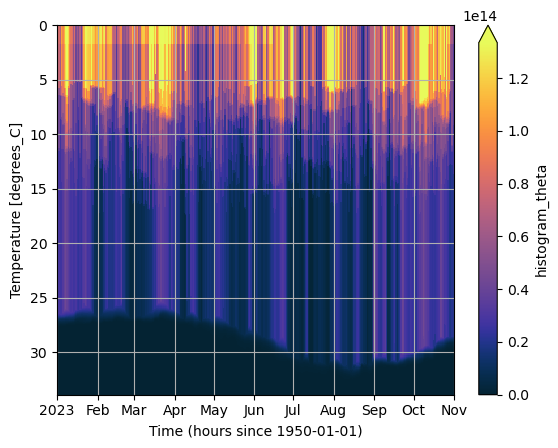

In [38]:
V = tdist.isel(theta_bin=slice(None, None, -1)).cumsum(dim='theta_bin')
V.transpose().plot(yincrease=False, robust=True, cmap=cmocean.cm.thermal)
plt.grid();

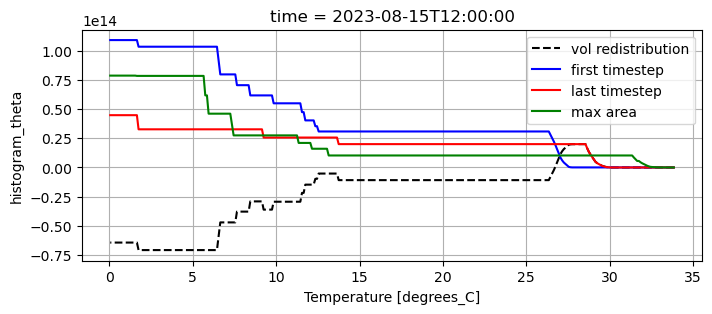

In [39]:
plt.figure(figsize=(8,3))
(V[-1] - V[0]).plot(color='k', label='vol redistribution', linestyle='dashed')
V[0].plot(label='first timestep', color='b')
V[-1].plot(label='last timestep', color='r')
V.sel(time='2023-08-15', method='nearest').plot(label='max area', color='green')
plt.legend()
#plt.xlim(1037, 1037.3)
plt.grid();

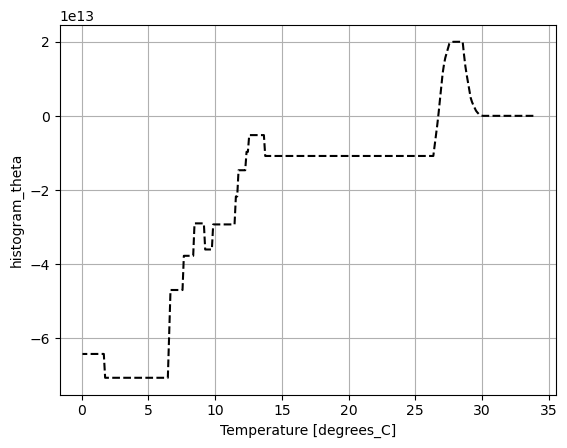

In [40]:
(V[-1] - V[0]).plot(color='k', label='vol redistribution', linestyle='dashed')
plt.grid();

In [41]:
V

<xarray.DataArray 'histogram_theta' (time: 304, theta_bin: 339)>
dask.array<nancumsum, shape=(304, 339), dtype=float32, chunksize=(1, 339), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00
  * theta_bin  (theta_bin) float64 33.85 33.75 33.65 33.55 ... 0.25 0.15 0.05

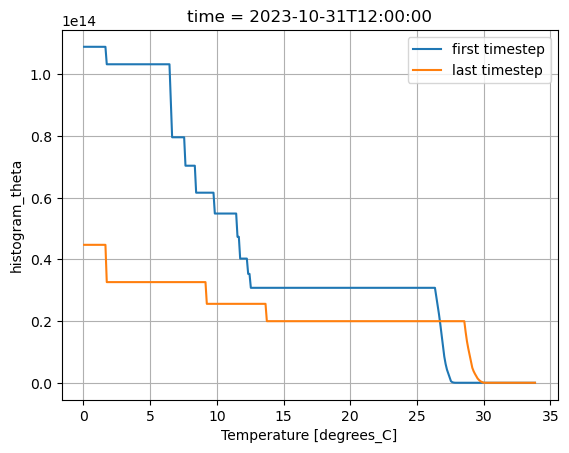

In [42]:
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.grid();

In [43]:
V.theta_bin

<xarray.DataArray 'theta_bin' (theta_bin: 339)>
array([33.85, 33.75, 33.65, ...,  0.25,  0.15,  0.05])
Coordinates:
  * theta_bin  (theta_bin) float64 33.85 33.75 33.65 33.55 ... 0.25 0.15 0.05
Attributes:
    _ChunkSizes:    [1, 6, 256, 540]
    cell_methods:   area: mean
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    unit_long:      Degrees Celsius
    units:          degrees_C

In [44]:
V.sel(theta_bin=slice(None, 31.8))#.plot()

<xarray.DataArray 'histogram_theta' (time: 304, theta_bin: 21)>
dask.array<getitem, shape=(304, 21), dtype=float32, chunksize=(1, 21), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00
  * theta_bin  (theta_bin) float64 33.85 33.75 33.65 33.55 ... 32.05 31.95 31.85

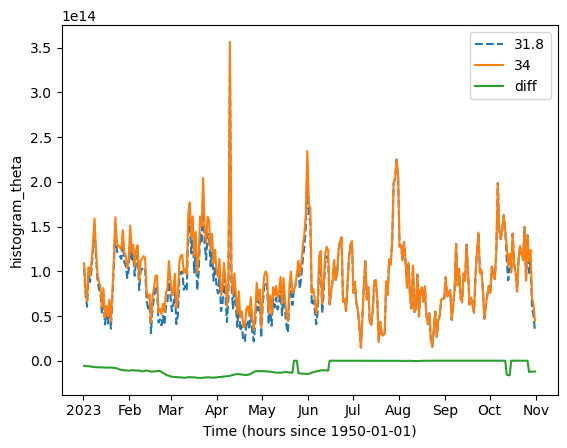

In [45]:
#checking what the diff is in volumbe of the lowest and highest temp threshold (31.8-34˚C)
V.sel(theta_bin=3.18, method='nearest').plot(label='31.8', linestyle='dashed')
V.isel(theta_bin=-1).plot(label='34')
(V.sel(theta_bin=3.18, method='nearest') - V.isel(theta_bin=-1)).plot(label='diff')
plt.legend()
plt.grid;

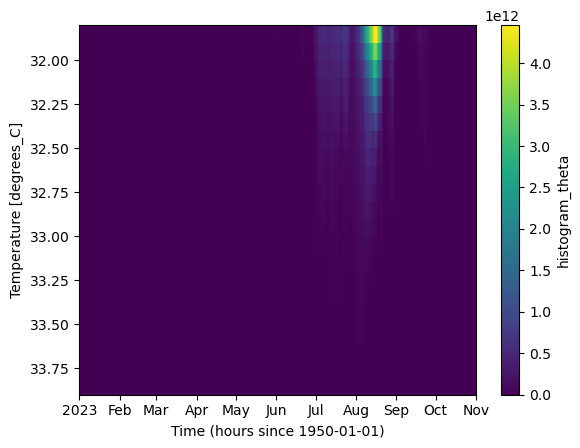

In [46]:
V.sel(theta_bin=slice(None, 31.8)).T.plot(yincrease=False)

In [47]:
(np.diff(V.time)/1e9)[0]

numpy.timedelta64(86400,'ns')

In [48]:
delta_V = V.diff(dim='time')
dVdt = delta_V / 86400

In [49]:
dVdt

<xarray.DataArray 'histogram_theta' (time: 303, theta_bin: 339)>
dask.array<truediv, shape=(303, 339), dtype=float64, chunksize=(1, 339), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2023-01-02T12:00:00 ... 2023-10-31T12:00:00
  * theta_bin  (theta_bin) float64 33.85 33.75 33.65 33.55 ... 0.25 0.15 0.05

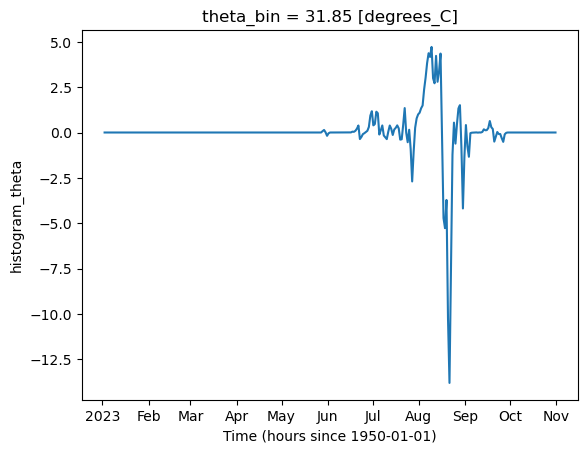

In [50]:
(dVdt/1e6).sel(theta_bin=31.8, method='nearest').plot()

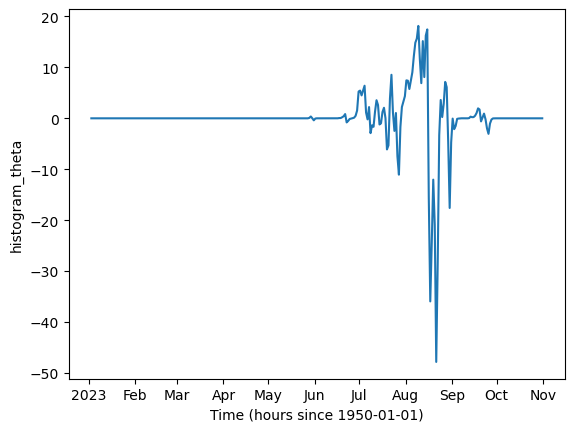

In [51]:
(dVdt/1e6).sel(theta_bin=slice(None, 31.8)).sum('theta_bin').plot()

In [52]:
tdist

<xarray.DataArray 'histogram_theta' (time: 304, theta_bin: 339)>
dask.array<sum-aggregate, shape=(304, 339), dtype=float32, chunksize=(1, 339), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00
  * theta_bin  (theta_bin) float64 0.05 0.15 0.25 0.35 ... 33.65 33.75 33.85

In [53]:
tdist.sel(theta_bin=slice(31.8, None))

<xarray.DataArray 'histogram_theta' (time: 304, theta_bin: 21)>
dask.array<getitem, shape=(304, 21), dtype=float32, chunksize=(1, 21), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00
  * theta_bin  (theta_bin) float64 31.85 31.95 32.05 32.15 ... 33.65 33.75 33.85

In [54]:
V32 = tdist.sel(theta_bin=slice(31.8, None)).sum('theta_bin')

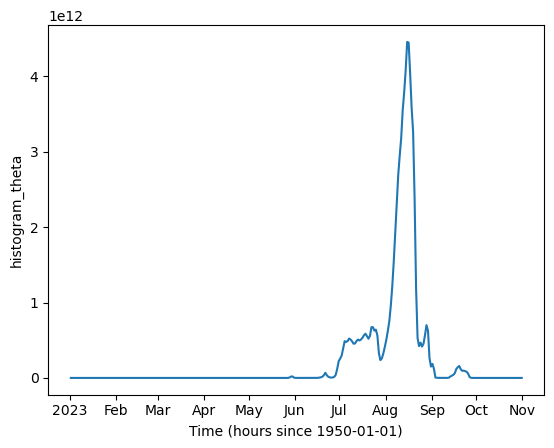

In [55]:
V32.plot()

In [56]:
delta_V32 = V32.diff(dim='time')
dVdt32 = delta_V32 / 86400

In [57]:
dVdt32

<xarray.DataArray 'histogram_theta' (time: 303)>
dask.array<truediv, shape=(303,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2023-01-02T12:00:00 ... 2023-10-31T12:00:00

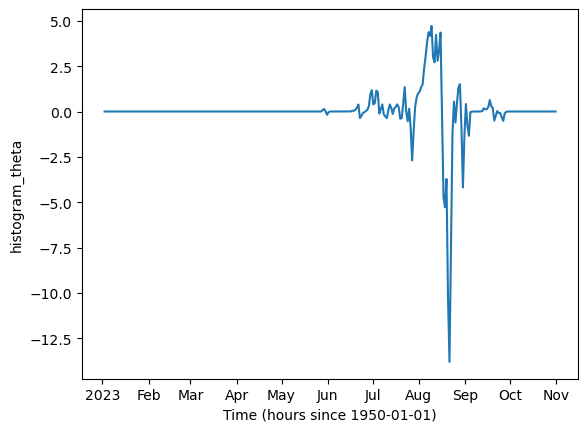

In [58]:
(dVdt32/1e6).plot()

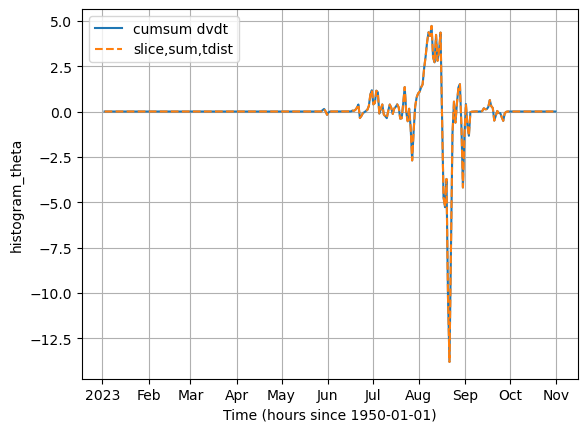

In [60]:
(dVdt/1e6).sel(theta_bin=31.8, method='nearest').plot(label='cumsum dvdt')
(dVdt32/1e6).plot(label='slice,sum,tdist', linestyle='dashed')
plt.legend()
plt.grid()

## another way to calculate dVdt (end)

In [82]:
#uploading dVdt
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOPAF/datasets/dVdt.zarr')
dVdt32.to_zarr(gcsmap_ds, mode='w')